# Calculate ffCO2

Use time varying APO:ffCO2 ratios to calculate ffCO2 from the APO model \
Can test masking the ocean to prevent it affecting the ffCO2 estimates

We weight the APO:ffCO2 ratio for each timestep depending on the footprint

In [1]:
import os
import sys
import glob
import regionmask
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs
from acrg.convert import concentration

sys.path.append(os.environ['FUNCS'])
import apo_funcs, apo_emiss_func, apo_plot_info, apo_filter


In [2]:
year = 2014
months = [8, 12] # [7, 8, 9, 10, 11, 12] #[1, 2, 3, 4, 5, 6] #, 
site = 'WAO'
ox_ratio_inv = ['gridfed-ukghg']#, 'gridfed']

alpha_l = 1.07

starts = {month: datetime(year, month, 1) for month in months}
ends = {month: start + relativedelta(months=1) for month, start in starts.items()}

ocean = 'nonmasked' # -3 #'masked' #
date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}01-06' if months== [mm for mm in range(1, 7)] else \
           f'{year}07-12' if months== [mm for mm in range(7, 13)] else None

## Calculate the APO:ffCO2 ratio

1. Import the footprint
2. Find the proportion of footprint within each grid cell
3. Import the oxidative ratio
4. Multiply the oxidative ratio by the weighted footprint to get a weighted oxidative ratio map
5. Sum the weighted oxidative ratio map

In [3]:
footprints = {month: name.footprints(site, met_model='UKV',
                                     start = start,
                                     end = ends[month],
                                     domain = 'EUROPE',
                                     chunks = {'time': 50},
                                     species = 'co2')
              for month, start in starts.items()}

Reading and concatenating files: 
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201408.nc


### Calculate the weighting

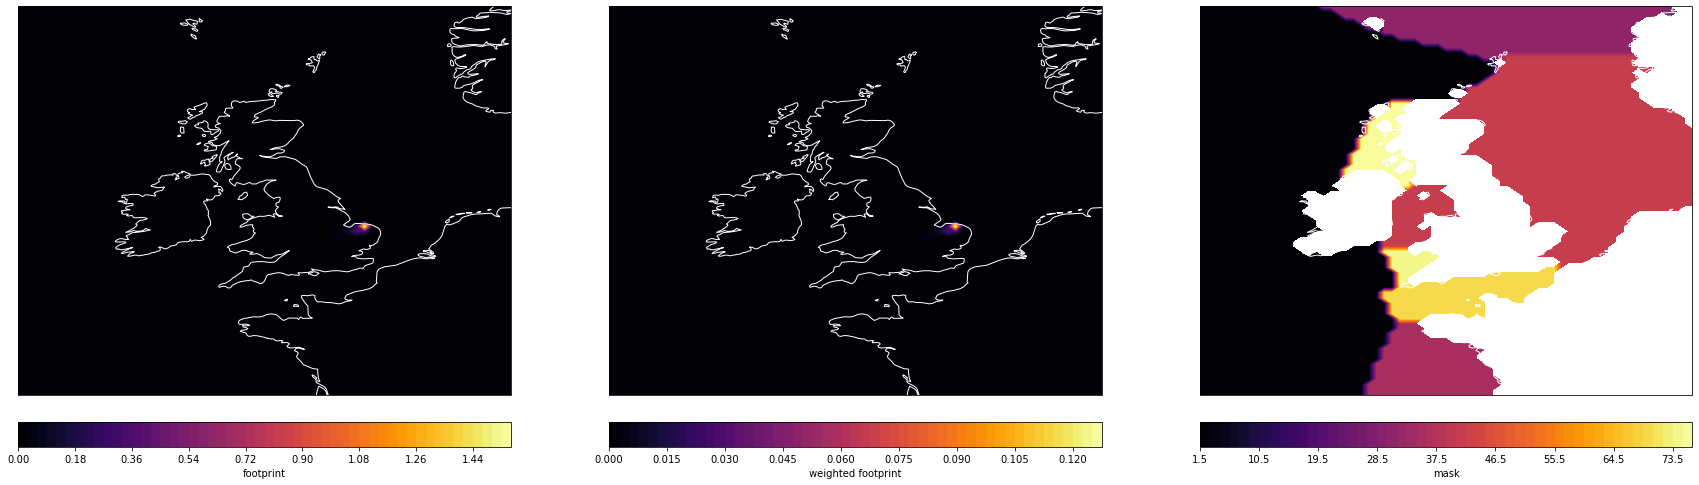

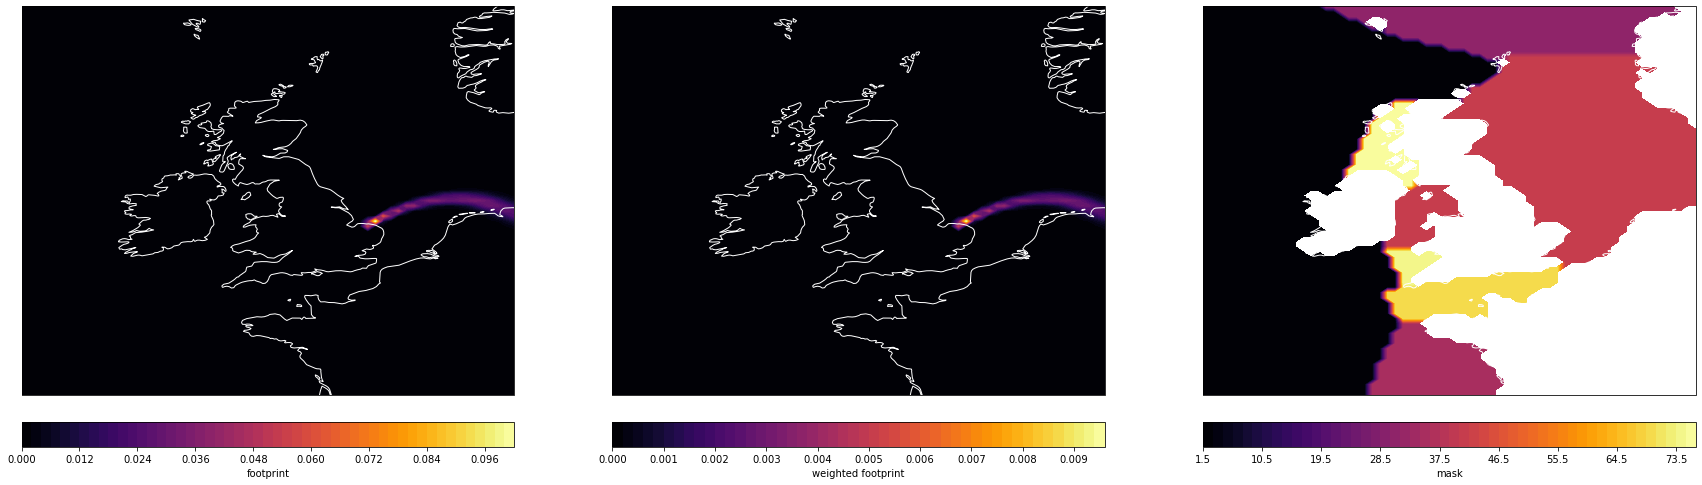

In [4]:
basins = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50
mask = basins.mask(footprints[months[0]].lon, footprints[months[0]].lat)


fp_masked = {month: footprint.fp.where(mask.isnull()) if ocean=='masked' else footprint.fp
             for month, footprint in footprints.items()}

fp_total = {month: fp.sum(dim=['lat', 'lon']) for month, fp in fp_masked.items()}
fp_ratio = {month: fp / fp_total[month] for month, fp in fp_masked.items()}

ax = {month: apo_funcs.show_map(data = [footprints[month].fp[:,:,0], fp_month[:,:,0], mask],
                               crop_uk = True,
                               coast_color='white',
                               colorbar_label_kwargs={'label':['footprint', 'weighted footprint', 'mask']})
      for month, fp_month in fp_ratio.items()}

### Import the oxidative ratios

In [5]:
oxidative_ratio_ds = {month: {inv: name.flux(domain = 'EUROPE',
                                             species = f'oxidativeratio-{inv}-1hr',
                                             start = start,
                                             end = ends[month],
                                             chunks = {'time': 50})
                              for inv in ox_ratio_inv}
                      for month, start in starts.items()}


Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/oxidativeratio-gridfed-ukghg-1hr_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/oxidativeratio-gridfed-ukghg-1hr_EUROPE_2014.nc
Slicing time to range 2014-08-01 00:00:00 - 2014-08-31 23:59:59

Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/oxidativeratio-gridfed-ukghg-1hr_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/oxidativeratio-gridfed-ukghg-1hr_EUROPE_2014.nc
/group/chemistry/acrg/LPDM/emissions/EUROPE/oxidativeratio-gridfed-ukghg-1hr_EUROPE_2015.nc
Slicing time to range 2014-12-01 00:00:00 - 2014-12-31 23:59:59


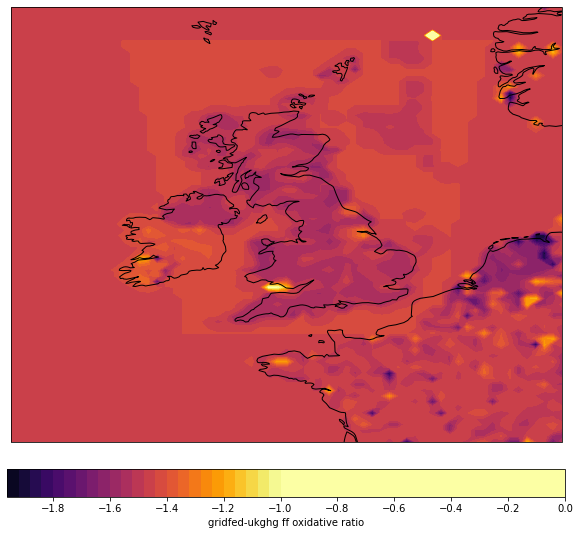

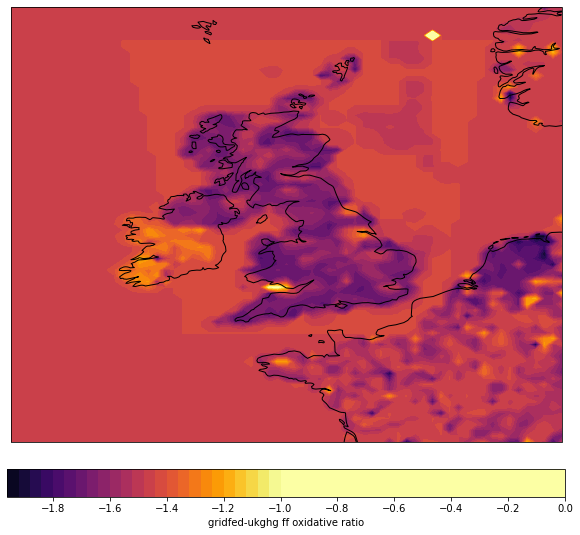

In [6]:
# oxidative_ratio_ds['ukghg'] = oxidative_ratio_ds['ukghg'].where(abs(flux_data.flux[:,:,0])>1e-8)
oxidative_ratio_data = {month: [ox.flux[:,:,0] for ox in ox_month.values()] for month, ox_month in oxidative_ratio_ds.items()}
oxidative_ratio_labels = [f'{inv} ff oxidative ratio' for inv in oxidative_ratio_ds[months[0]].keys()]
ax = {month: apo_funcs.show_map(data = ox_month,
                               crop_uk = True,
                               colorbar_label_kwargs={'label': oxidative_ratio_labels},
                               im_kwargs={'vmin':-2, 'vmax':-1})
      for month, ox_month in oxidative_ratio_data.items()}

### Mask the ocean

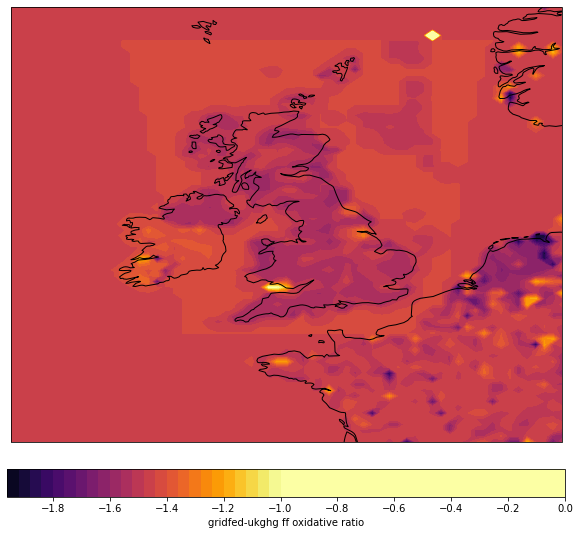

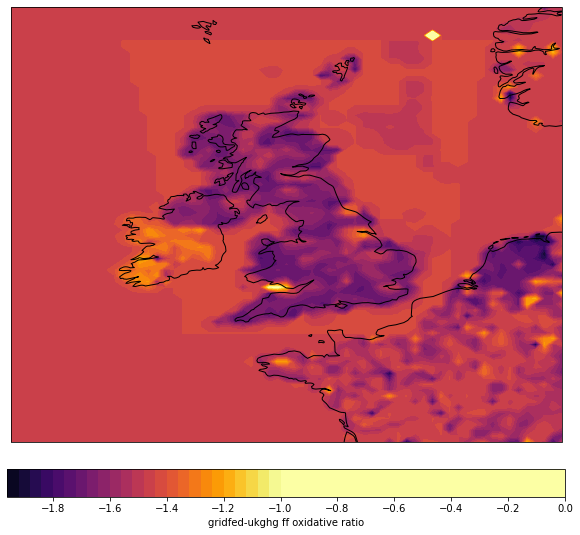

In [7]:
if ocean == 'nonmasked':
   oxidative_ratio_masked = {month: {inv: ox.flux for inv, ox in ox_month.items()}
                             for month, ox_month in oxidative_ratio_ds.items()}
else:
    other = None if ocean=='masked' else ocean
    oxidative_ratio_masked = {month: {inv: ox.flux.where(mask.isnull(), other=other) for inv, ox in ox_month.items()}
                              for month, ox_month in oxidative_ratio_ds.items()}

oxidative_ratio_data = {month: [ox[:,:,0] for ox in ox_month.values()] for month, ox_month in oxidative_ratio_masked.items()}
ax = {month: apo_funcs.show_map(data =  ox_month,
                               crop_uk = True,
                               colorbar_label_kwargs={'label': oxidative_ratio_labels},
                               im_kwargs={'vmin':-2, 'vmax':-1})
      for month, ox_month in oxidative_ratio_data.items()}

### Get the weighted oxidative ratio

Multiply the oxidative ratios by the footprint ratio to weight them

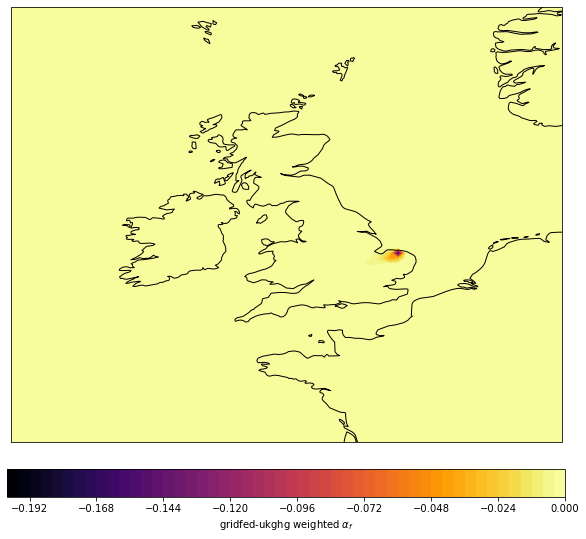

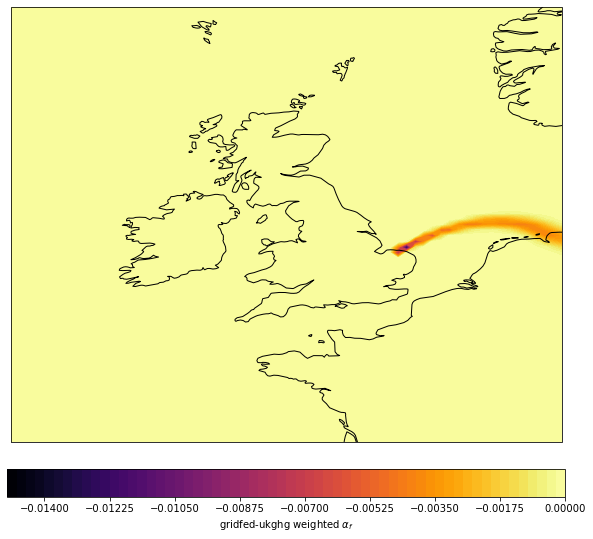

In [8]:
for month, ox_month in oxidative_ratio_ds.items():
    for ratio in ox_month.values():
        for ll in ['lat', 'lon']:
            ratio[ll] = fp_ratio[month][ll]
oxidative_ratio_weighted = {month: {inv: ratio * fp_ratio[month] for inv, ratio in ox_month.items()}
                            for month, ox_month in oxidative_ratio_masked.items()}

data = {month: [oxratio[:,:,0] for oxratio in ox_month.values()] for month, ox_month in oxidative_ratio_weighted.items()}
labels = [f'{inv} weighted '+r'$\alpha_f$' for inv in oxidative_ratio_weighted[months[0]].keys()]

ax = {month: apo_funcs.show_map(data = dat_month,
                               crop_uk = True,
                               coast_color='black',
                               colorbar_label_kwargs={'label': labels})
      for month, dat_month in data.items()}

### Plot the total weighted oxidative ratio

Plot the average oxidative ratio at each time step

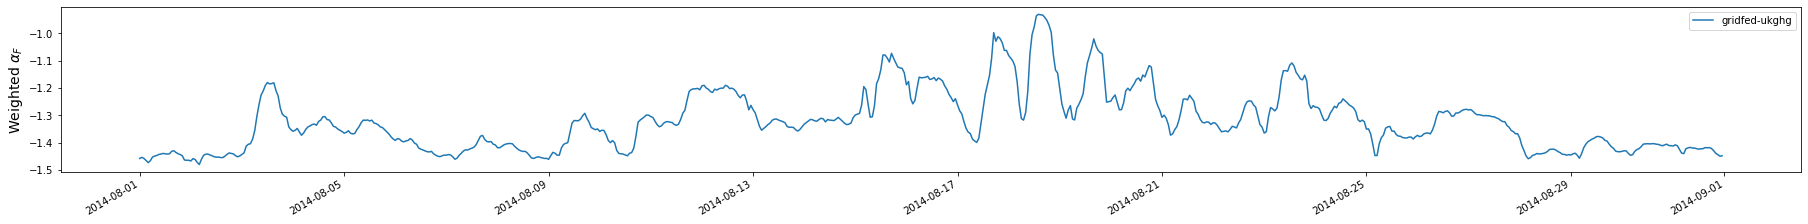

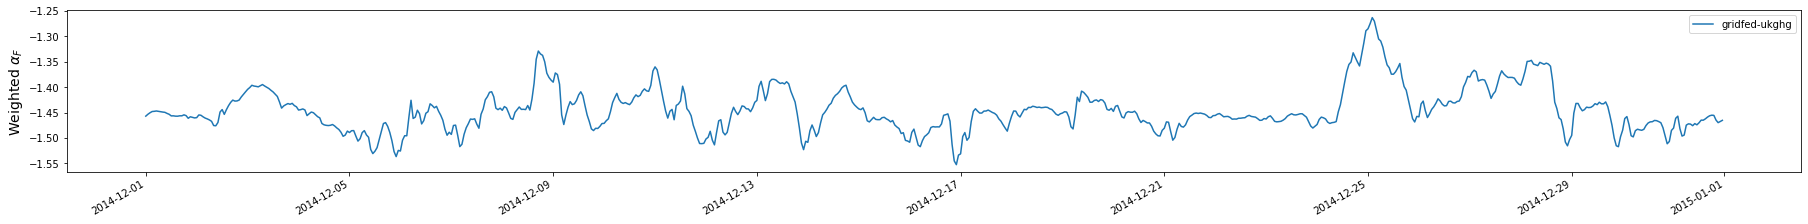

In [29]:
oxidative_ratio_weighted_total = {month: {inv: (ratio).sum(dim=['lat', 'lon'])
                                          for inv, ratio in ox_month.items()}
                                  for month, ox_month in oxidative_ratio_weighted.items()}

for month, ox_month in oxidative_ratio_weighted_total.items():
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 3), sharex=True, constrained_layout=True)

    plots = [ratio.plot(ax=ax, label=inv) for inv, ratio in ox_month.items()]
    ylabel = ax.set_ylabel(r'Weighted $\alpha_F$', fontsize=14)
    xlabel = ax.set_xlabel('')
    legend = ax.legend(loc='best')

## Get the APO:ffCO $_2$ ratio

APO:ffCO2 = $\alpha_f$ + 1.1

Assuming biospheric ratio of: 1.07


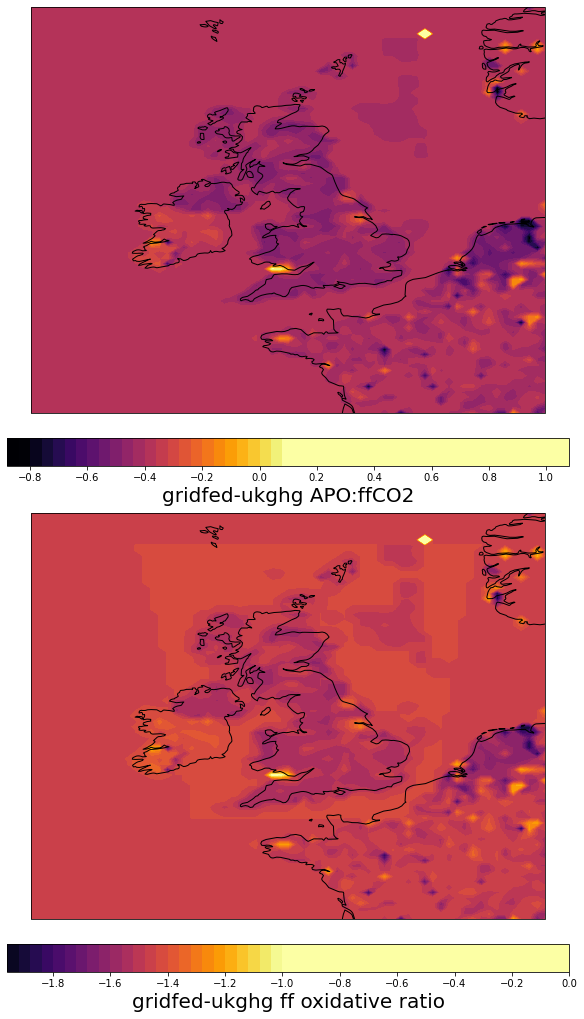

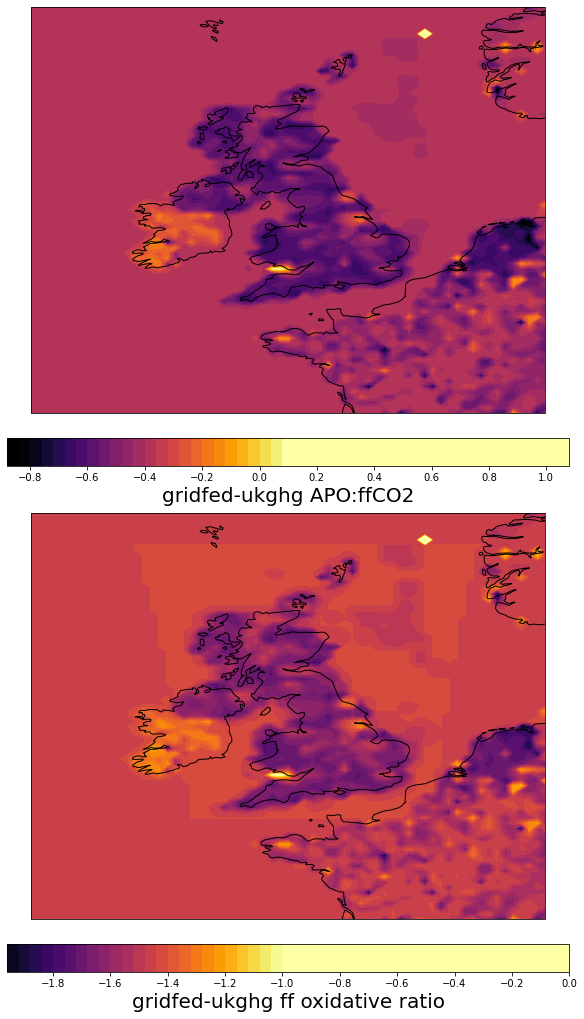

In [9]:
print(f'Assuming biospheric ratio of: {alpha_l}')
apo_ffco2_ratio = {month: {inv: ox + alpha_l for inv, ox in ox_month.items()}
                   for month, ox_month in oxidative_ratio_masked.items()}

data = {month: [apo[:,:,0] for apo in ratio.values()] for month, ratio in apo_ffco2_ratio.items()}
# vmin = np.array([np.nanpercentile(dat, 1) for dat in data]).min()

labels = [f'{inv} APO:ffCO2' for inv in apo_ffco2_ratio[months[0]].keys()]
im_kwargs = [{'vmin': -0.83, 'vmax': 0.1}]*len(ox_ratio_inv) + [{'vmin': -2, 'vmax': -1}]*len(ox_ratio_inv)
ax = {month: apo_funcs.show_map(data = data[month]+ox_month,
                               crop_uk = True,
                               colorbar_label_kwargs={'label': labels+oxidative_ratio_labels, 'fontsize': 20},
                               fig_kwargs={'nrows':2, 'ncols':len(ox_ratio_inv), 'figsize':(8*len(ox_ratio_inv),14), 'constrained_layout': True},
                               im_kwargs = im_kwargs)
      for month, ox_month in oxidative_ratio_data.items()}

### Get the weighted APO:ffCO $_2$ ratio

$R_{t, APO:CO_2} = \sum_{j=0}^{n}(\alpha_{Ft,j}+1.1) \frac{fp_{t,j}}{\sum_{j=0}^n fp_t}$

Multiply the APO:ffCO2 ratio by the footprint ratio to get a weighted APO:ffCO2 ratio

In [10]:
for month, ratios in apo_ffco2_ratio.items():
    for apo in ratios.values():
        for ll in ['lat', 'lon']:
            apo[ll] = fp_ratio[month][ll]
apo_ffco2_ratio_weighted = {month: {inv: ratio * fp_ratio[month] for inv, ratio in ratios.items()}
                            for month, ratios in apo_ffco2_ratio.items()}

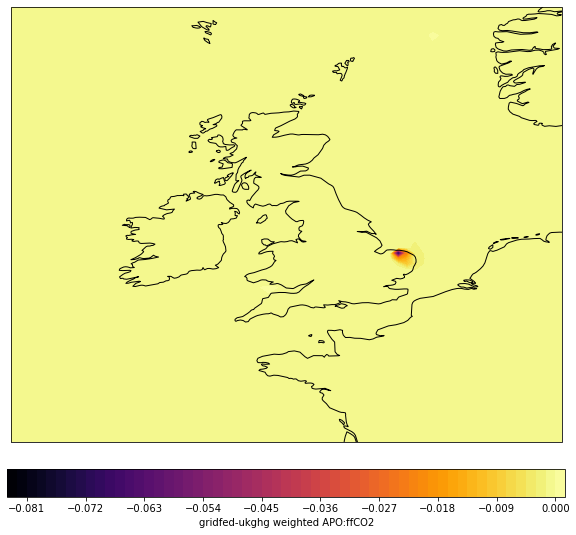

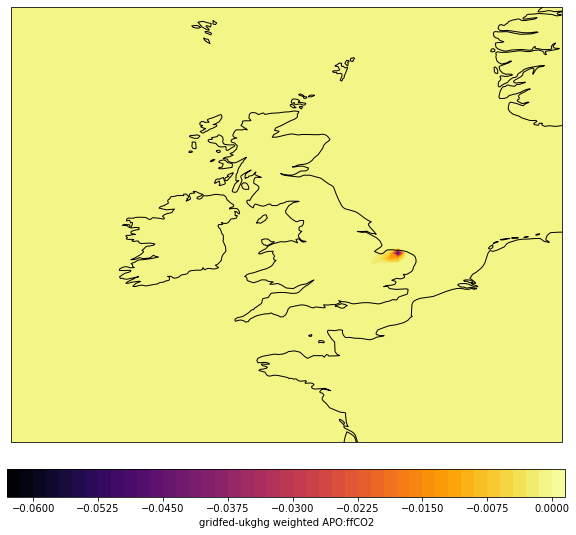

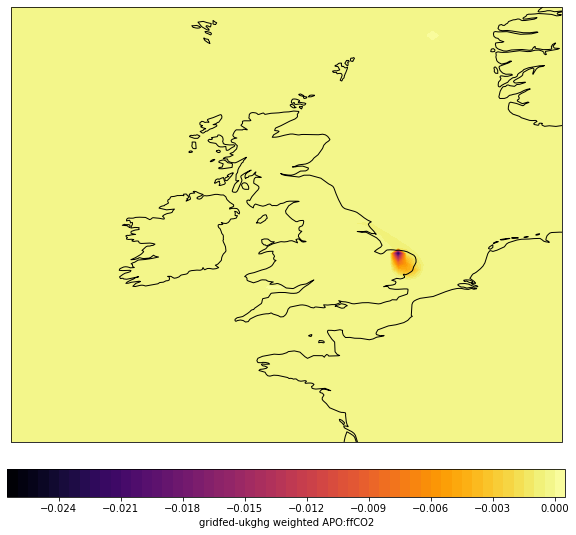

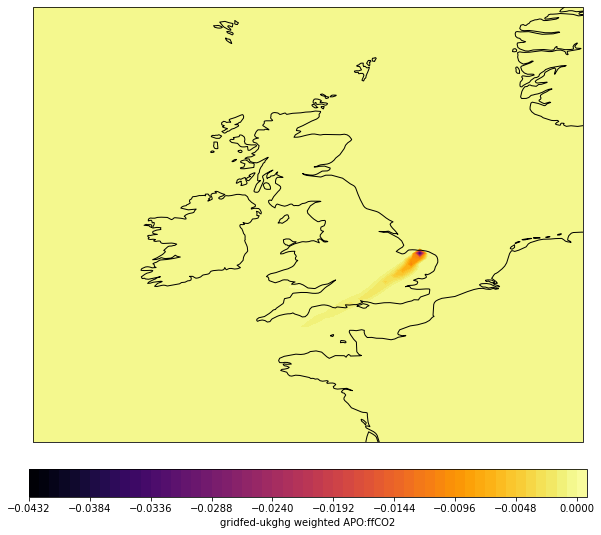

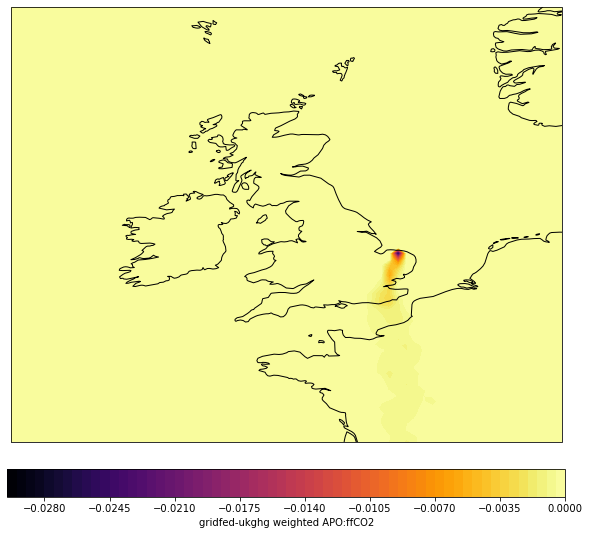

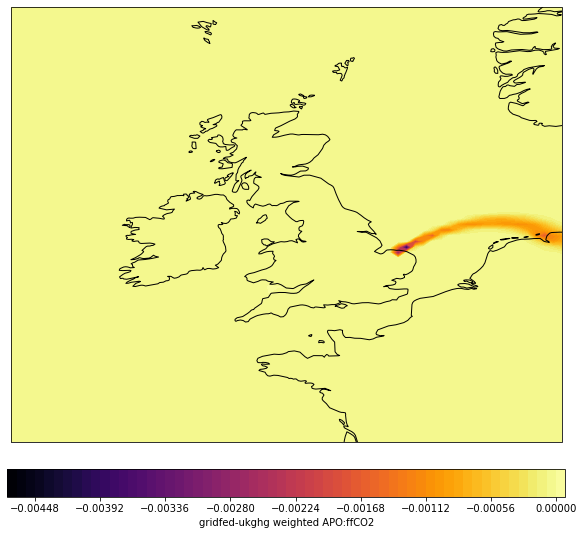

In [11]:
data = {month: [apo[:,:,0] for apo in ratios.values()]
        for month, ratios in apo_ffco2_ratio_weighted.items()}
labels = [f'{inv} weighted APO:ffCO2' for inv in apo_ffco2_ratio_weighted[months[0]].keys()]
ax = {month: apo_funcs.show_map(data = dat_month,
                               crop_uk = True,
                               coast_color='black',
                            #    im_kwargs = im_kwargs,
                               colorbar_label_kwargs={'label': labels})
      for month, dat_month in data.items()}

apo_ffco2_weighted_total = {month: {inv: ratio.sum(dim=['lat', 'lon']) for inv, ratio in ratios.items()}
                            for month, ratios in apo_ffco2_ratio_weighted.items()}

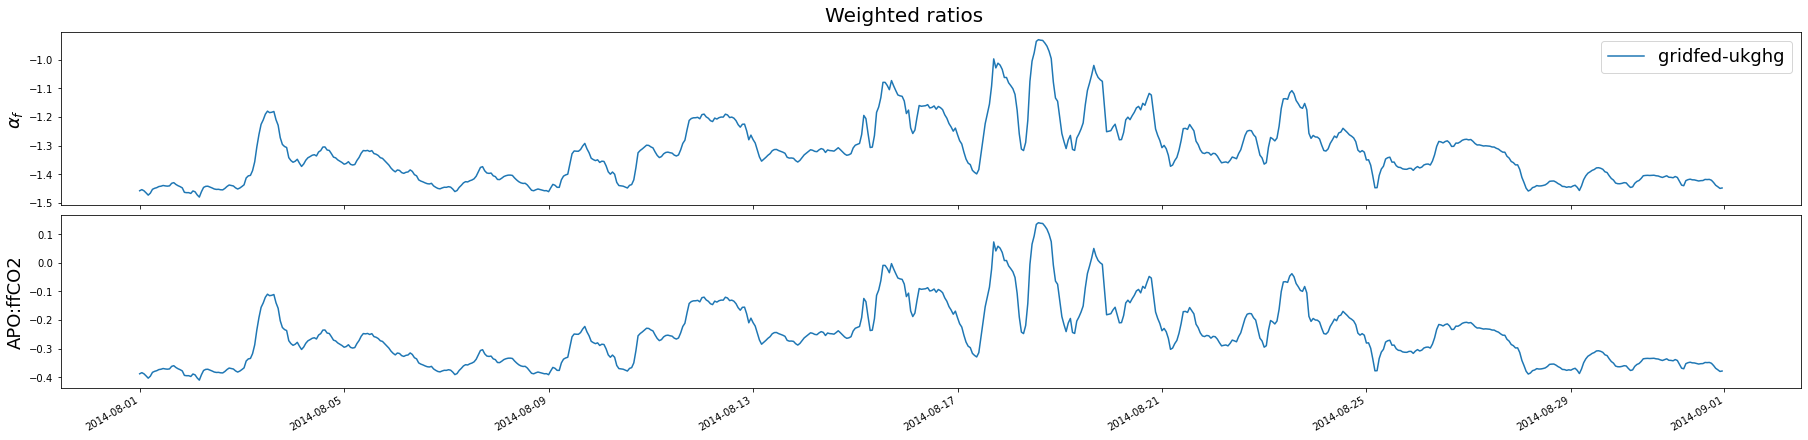

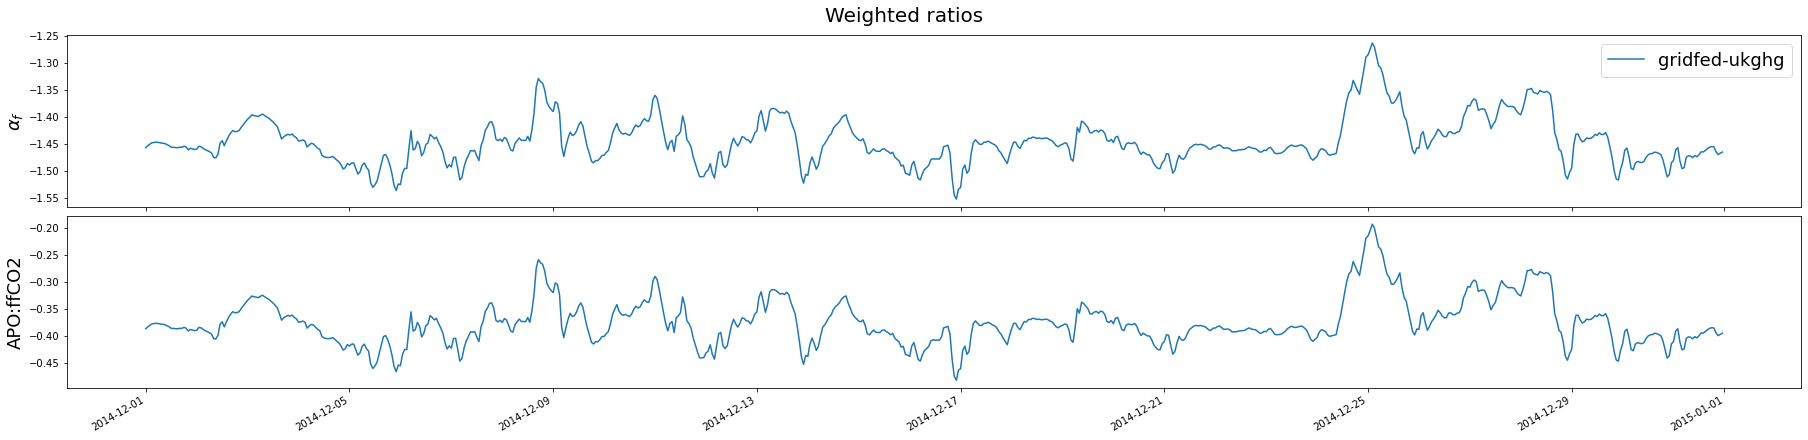

In [33]:
# check = {inv: ratio+1.1 for inv, ratio in oxidative_ratio_weighted_total.items()}
label_fontsize = 18

for month, ratios in apo_ffco2_weighted_total.items():
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25, 6), sharex=True, constrained_layout=True)
    plots = [ratio.plot(ax=axes[0], label=inv) for inv, ratio in oxidative_ratio_weighted_total[month].items()]
    plots = [ratio.plot(ax=axes[1], label=inv) for inv, ratio in ratios.items()]
    ylab = axes[0].set_ylabel(r'$\alpha_f$', fontsize=label_fontsize)
    ylab = axes[1].set_ylabel('APO:ffCO2', fontsize=label_fontsize)

    legend = axes[0].legend(loc='best', fontsize = label_fontsize)

    fig.suptitle('Weighted ratios', fontsize=20)
    xlab = [ax.set_xlabel('') for ax in axes]


## Get the APO timeseries

Get the timeseries for the site and the backround (MHD)

In [10]:
ts_data_all = apo_funcs.get_timeseries(sites = [site],
                                      year = year,
                                      sources = ['bc', 'ff', 'ocean'])
ts_data_months = {site: {month: ts_site.sel(time=slice(start, ends[month]))
                         for month, start in starts.items()}
                  for site, ts_site in ts_data_all.items()}

Finding timeseries for WAO
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2014.nc']
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2014.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2014.nc']

Data variables:
['co2_ff', 'apo_bc', 'co2_bc', 'o2_bc', 'o2_ff', 'o2_ocean_nemo', 'n2_ocean_nemo', 'o2_ocean_ecco', 'o2_ocean_jena', 'co2_ocean_nemo']


## Test retrieving ffCO2 from ffO2

We use the weighted oxidative ratio timeseries to retrieve the ffCO2

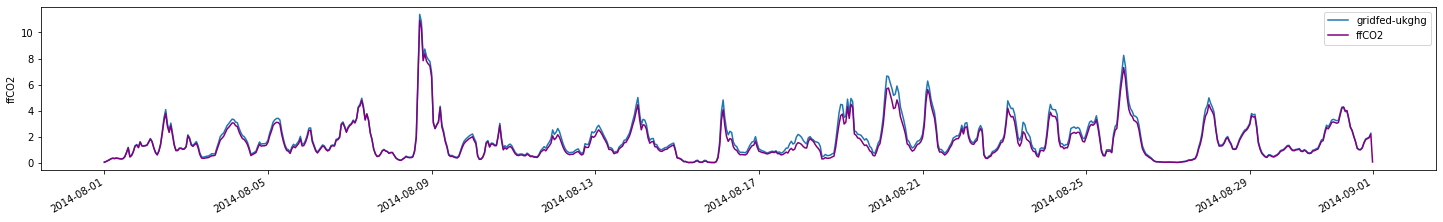

In [12]:
oxidative_ratio_weighted_total = {month: {inv: (ratio).sum(dim=['lat', 'lon'])
                                          for inv, ratio in ox_month.items()}
                                  for month, ox_month in oxidative_ratio_weighted.items()}

ff_co2 = {inv: ts_data_months[site][months[0]]['o2_ff'] / ox_ratio for inv, ox_ratio in oxidative_ratio_weighted_total[months[0]].items()}

fig, ax = plt.subplots(1, 1, figsize=(25, 3))
[ff_co2_inv.plot(ax=ax, label=inv) for inv, ff_co2_inv in ff_co2.items()]
ts_data_months[site][months[0]].co2_ff.plot(ax=ax, color='purple', label='ffCO2')
legend = ax.legend(loc='best')
xlabel = ax.set_xlabel('')
ylabel = ax.set_ylabel('ffCO2')

### Calculate APO and ffCO2

In [13]:
apo_model = {site_name: {month: {ocean_sim: apo_emiss_func.apo(ocean_o2 = ts_month[f'o2_ocean_{ocean_sim}'],
                                                               ocean_co2 = ts_month.co2_ocean_nemo,
                                                               ocean_n2 = ts_month.n2_ocean_nemo,
                                                               ff_co2 = ts_month.co2_ff,
                                                               ff_o2 = ts_month.o2_ff) #+ ts_site.apo_bc 
                                for ocean_sim in ['ecco', 'jena', 'nemo']}
                        for month, ts_month in ts_site.items()}
            for site_name, ts_site in ts_data_months.items()}

ffco2 = {site: {month: {ocean_sim: {inv: apo_ocean / ratio
                                    for inv, ratio in ratio_month.items()}
                        for ocean_sim, apo_ocean in apo_site[month].items()}
                for month, ratio_month in apo_ffco2_weighted_total.items()}
         for site, apo_site in apo_model.items()}

### Plot ffCO2

In [14]:
### plot the modelled ffCO2 with a varying oxidative ratio
inv_plot = ['gridfed', 'gridfed-ukghg']
sim_plot = ['ecco', 'jena', 'nemo']
sim_names = {'ecco': 'ECCO', 'jena': 'Jena', 'nemo': 'NEMO'}
color = {'gridfed': 'violet', 'gridfed-ukghg': 'dodgerblue'}
ls = {'gridfed': '--', 'gridfed-ukghg': '-.'}
label = {'gridfed': 'GridFED', 'gridfed-ukghg': 'GridFED-NAEI'} if len(ox_ratio_inv)>1 else \
        {ox_ratio_inv[0]: 'APO-derived'}

# convert the units to ppm
ffco2_ppm = {site: {month: {ocean_sim: {inv: ff_inv*0.2094 for inv, ff_inv in ff_ocean.items()}
                            for ocean_sim, ff_ocean in ff_month.items() if ocean_sim in sim_plot}
                    for month, ff_month in ffco2_site.items()}
             for site, ffco2_site in ffco2.items()}

ffco2_ppm = {site: {month: {ocean_sim: {inv: ff_inv.where((ff_inv>-40) & (ff_inv<40)).load()
                                        for inv, ff_inv in ff_ocean.items()}
                            for ocean_sim, ff_ocean in ff_month.items()}
                    for month, ff_month in ffco2_site.items()}
             for site, ffco2_site in ffco2_ppm.items()}


Saving to /user/work/vf20487/Figures/Timeseries/ffCO2/ffCO2_APO_WAO_201401-06.png


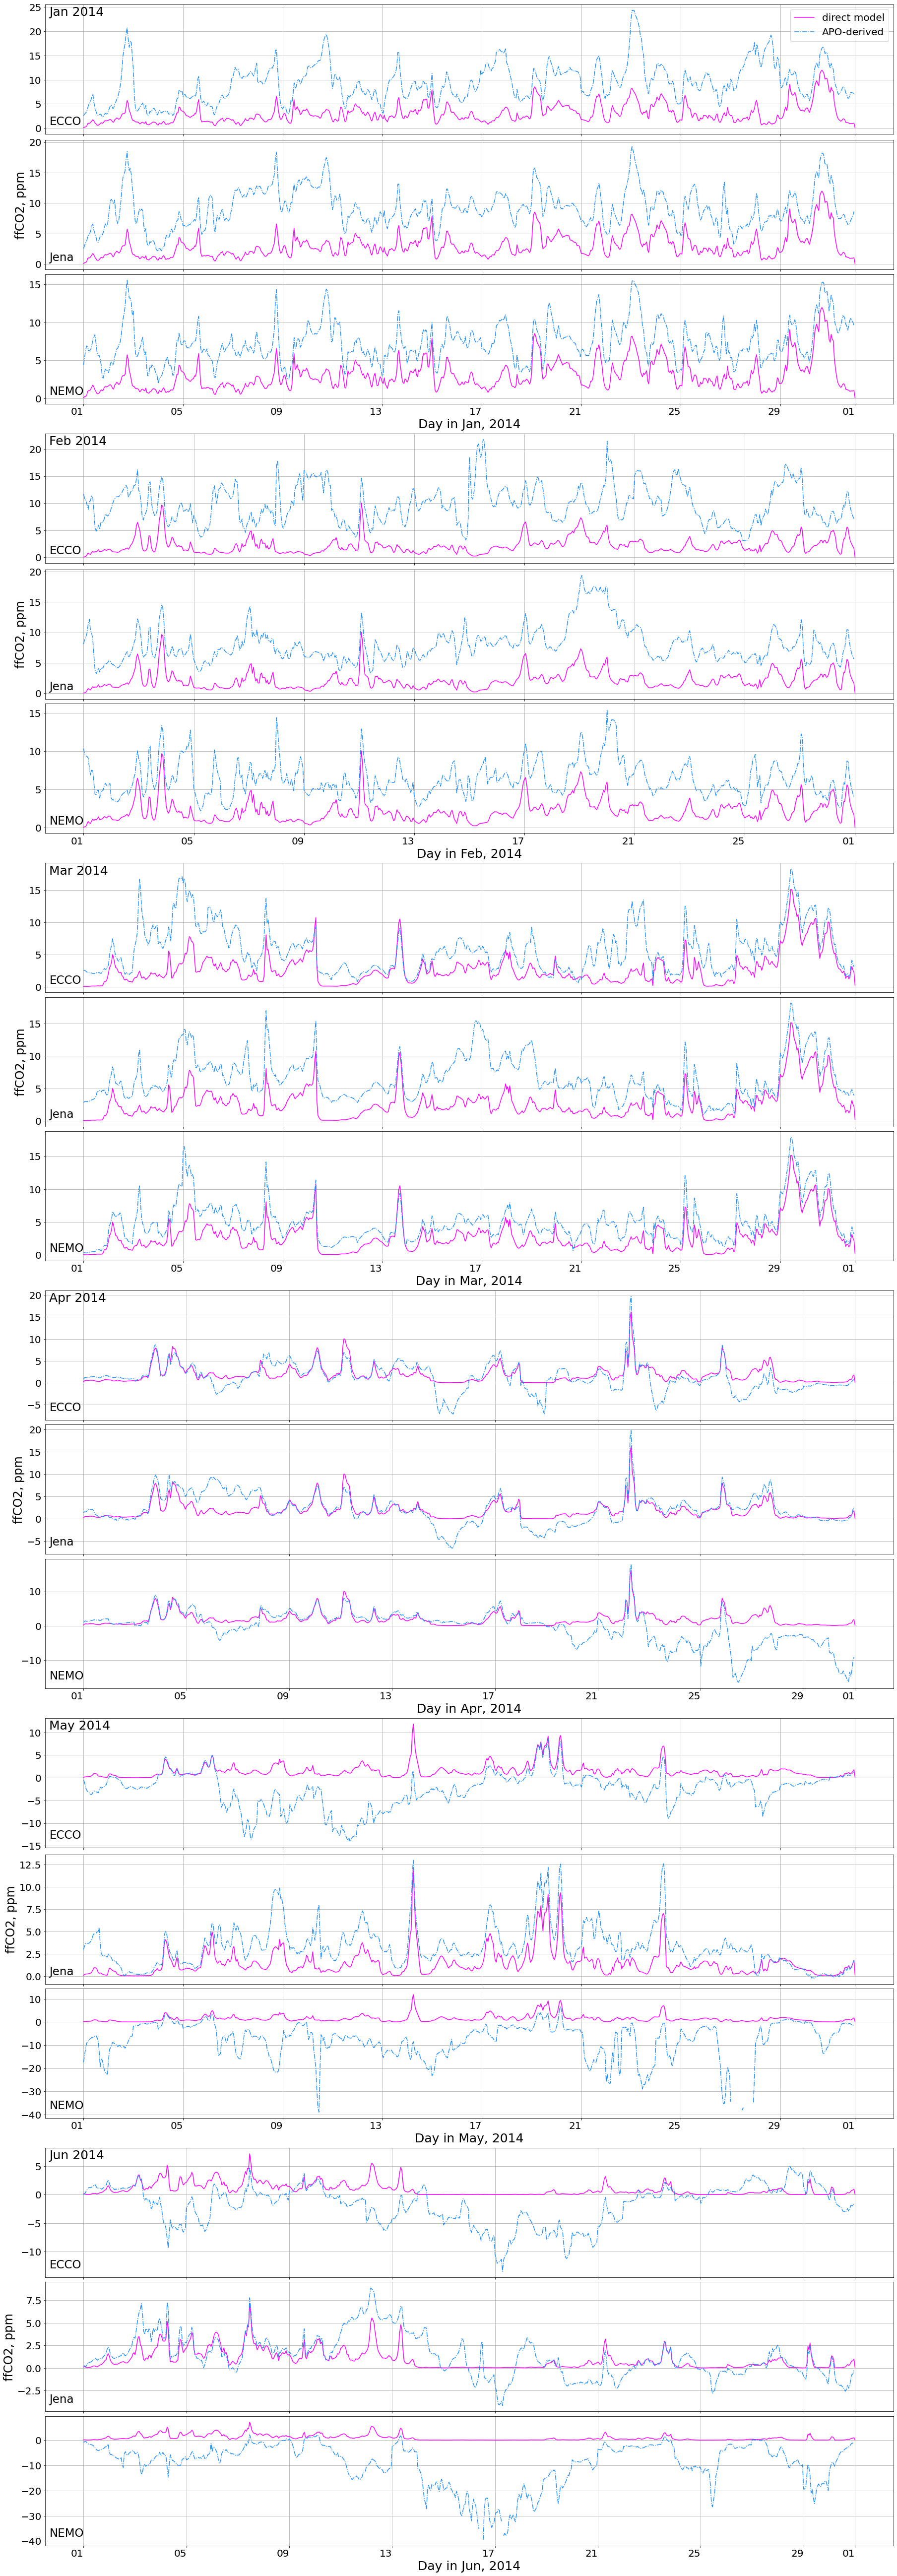

In [25]:
# plot the nemo & ecco models on separate axes
fig, axes = plt.subplots(nrows=len(sim_plot)*len(months), ncols=1, figsize=(25, 4*len(sim_plot)*len(months)), constrained_layout=True)
# height_ratios = sum([[4]*len(sim_plot) + [0.2] for mm in range(len(months)-1)], []) + [4]*len(sim_plot)
# fig, axes = plt.subplots(nrows=len(sim_plot)*len(months)+1, ncols=1, figsize=(25, 4*len(sim_plot)*len(months)), constrained_layout=True,
#                          gridspec_kw=dict(height_ratios=height_ratios, hspace=0))

# plot the NAEI timeseries
[[ts_data_month.co2_ff.plot(ax=axes[ii+tt*len(sim_plot)], label='direct model', color='magenta') for ii in range(len(sim_plot))]
 for tt, ts_data_month in enumerate(ts_data_months[site].values())]

# plot the APO-derived ffCO2 timeseries
apo_plots = {month: [[ff.plot(ax=axes[ss+mm*len(sim_plot)], label=label[inv], color=color[inv], ls=ls[inv])
                      for inv, ff in ff_ocean.items() if inv in inv_plot]
                     for ss, (sim, ff_ocean) in enumerate(ff_month.items())]
            for mm, (month, ff_month) in enumerate(ffco2_ppm[site].items())}
text = [[axes[ss+mm*len(sim_plot)].text(0.005, 0.05, sim_names[sim], transform=axes[ss+mm*len(sim_plot)].transAxes, va='bottom', fontsize=23)
         for ss, sim in enumerate(ff_month.keys())]
        for mm, (month, ff_month) in enumerate(ffco2_ppm[site].items())]

legend = axes[0].legend(loc='upper right', fontsize=20)
xlabel = [ax.set_xlabel('') for ax in axes]
[axes[m*len(sim_plot)+2].set_xlabel(f'Day in {apo_plot_info.month_names[month]}, {year}', fontsize=25)
 for m, month in enumerate(months)]
ylabel = [ax.set_ylabel('') for ax in axes]

if len(months)==1:
        ylabel = axes[1].set_ylabel('ffCO2, ppm', fontsize=24)
if len(months)==2:
        ylabel = fig.text(-0.01, 0.52, 'ffCO2, ppm', va='center', ha='center', rotation='vertical', fontsize=25)
else:
        ylabels = [axes[ii-1].set_ylabel('ffCO2, ppm', fontsize=24) for ii in [i for i in range(0, len(axes)) if (i+1)%3==0]]

myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
text = [axes[mm*3].text(0.005, 0.985, f'{plot_info.month_names[month]} {year}', transform=axes[mm*3].transAxes, va='top', fontsize=25)
        for mm, month in enumerate(months)]

ticks = [ax.tick_params(labelsize=20) for ax in axes]
[axes[ii].xaxis.set_ticklabels([]) for ii in range(0, len(axes)) if ii not in [m*len(sim_plot)+2 for m in range(0, len(months))]]
grid = [ax.grid() for ax in axes]

out_date_str = f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
               '_'.join([f'{year}{str(month).zfill(2)}' for month in months])
mask_str = '' if ocean=='nonmasked' else '_maskedocean' if ocean=='masked' else f'oceanOR{ocean}'
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'ffCO2',
                        f'ffCO2_APO{mask_str}_{site}_{out_date_str}.png')
print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

Saving to /user/work/vf20487/Figures/Timeseries/ffCO2/ffCO2_APO_all_WAO_201407-12.png


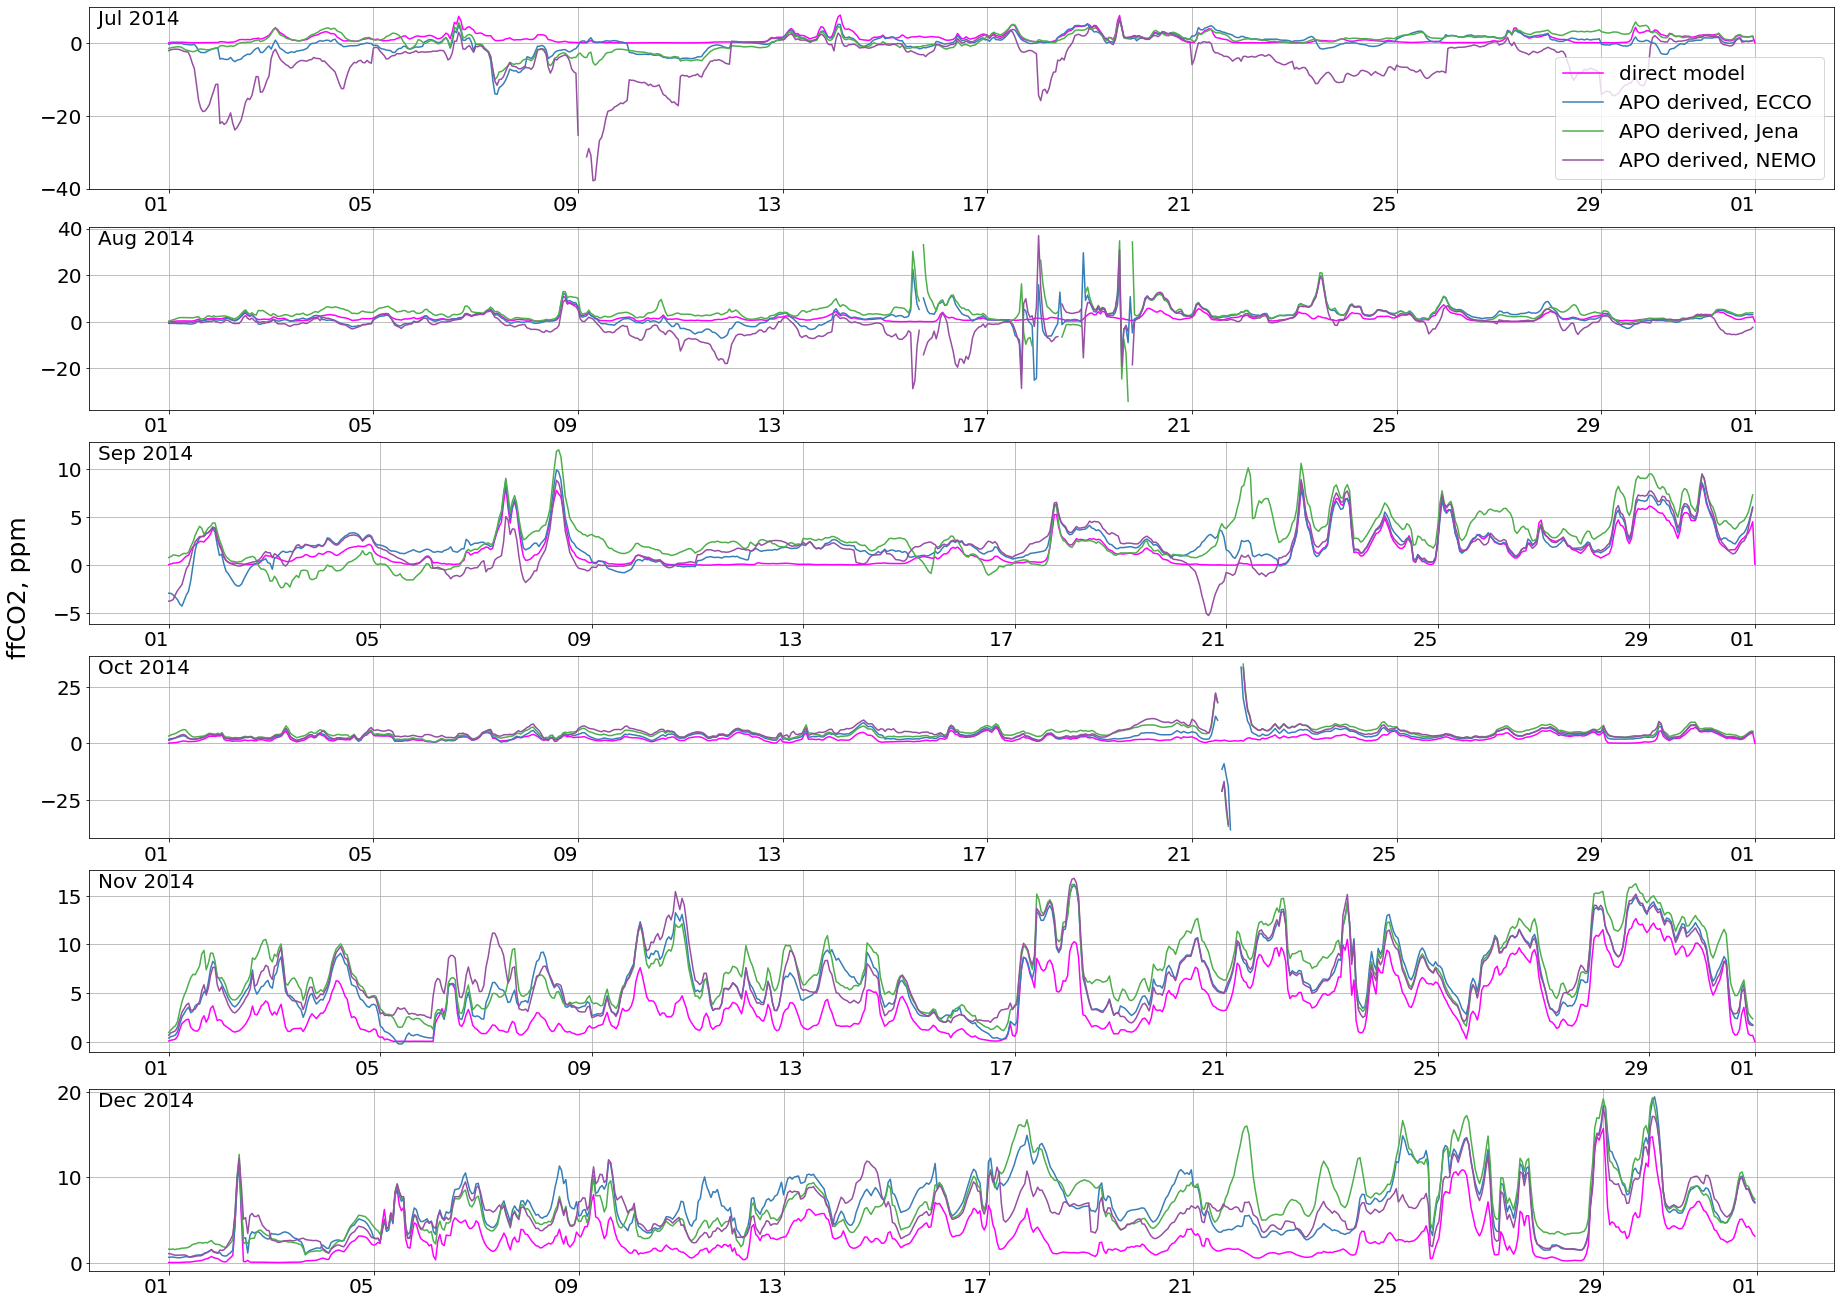

In [24]:
row_size = 5 if len(months)<=2 else 4
# plot the nemo & ecco models on separate axes
fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, row_size*len(months)), constrained_layout=True)
axes = [axes] if type(axes) not in [np.ndarray, list] else axes

# plot the NAEI timeseries
[ts_data_month.co2_ff.plot(ax=axes[tt], label='direct model', color='magenta')
 for tt, ts_data_month in enumerate(ts_data_months['WAO'].values())]

# labels = {sim: f'APO derived, {apo_plot_info.model_names[sim]}' for sim in ffco2_ppm['WAO'][1].keys()}
# plot the APO-derived ffCO2 timeseries
apo_plots = {month: [[ff.plot(ax=axes[mm], label=f'APO derived, {apo_plot_info.model_names[sim]}', color=apo_plot_info.colors[sim])
                      for inv, ff in ff_ocean.items() if inv in inv_plot]
                     for ss, (sim, ff_ocean) in enumerate(ff_month.items())]
            for mm, (month, ff_month) in enumerate(ffco2_ppm['WAO'].items())}

text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
        for mm, month in enumerate(ffco2_ppm['WAO'].keys())]

legend_loc = 'upper right' if months==[m for m in range(7)] else 'lower right'
legend = axes[0].legend(loc=legend_loc, fontsize=20)
xlabel = [ax.set_xlabel('') for ax in axes]
ylabel = [ax.set_ylabel('') for ax in axes]

if len(months)==1:
        ylabel = axes.set_ylabel('ffCO2, ppm', fontsize=24)
if len(months)>1:
        ylabel = fig.text(-0.01, 0.55, 'ffCO2, ppm', va='center', ha='center', rotation='vertical', fontsize=25)

myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
grid = [ax.grid() for ax in axes]

out_date_str = f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
               '_'.join([f'{year}{str(month).zfill(2)}' for month in months])
mask_str = '' if ocean=='nonmasked' else '_maskedocean' if ocean=='masked' else f'oceanOR{ocean}'
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'ffCO2',
                        f'ffCO2_APO_all{mask_str}_{site}_{out_date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Calculate ffCO2 from the obs

This part doesn't include subtracting a background so is wrong

In [48]:
apo_obs = {month: get_obs(([site]), 'APO', start, ends[month], keep_missing=True)
           for month, start in starts.items()}

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2014-08-01 00:00:00 to 2014-08-31 23:59:59.999999999
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2014-12-01 00:00:00 to 2014-12-31 23:59:59.999999999


In [67]:
ffco2_obs = {month: {site: {inv: apo_site[0].mf / ratio *0.2094
                            for inv, ratio in ratio_month.items()}
                    for site, apo_site in apo_obs[month].items()}
            for month, ratio_month in apo_ffco2_weighted_total.items()}
# ffco2_obs = {site: {month: {inv: ff_inv.where((ff_inv>-40) & (ff_inv<40)).load()
#                                         for inv, ff_inv in ff_month.items()}
#                     for month, ff_month in ffco2_site.items()}
#              for site, ffco2_site in ffco2_obs.items()}

ffco2_obs_const_ratio = {month: {site: apo_site[0].mf / (-1.7+1.1) * 0.2094
                                 for site, apo_site in apo_month.items()}
                         for month, apo_month in apo_obs.items()}
# ffco2_obs_const_ratio = {site: {month: ff_month.where((ff_month>-40) & (ff_month<40)).load()
#                     for month, ff_month in ffco2_site.items()}
#              for site, ffco2_site in ffco2_obs_const_ratio.items()}

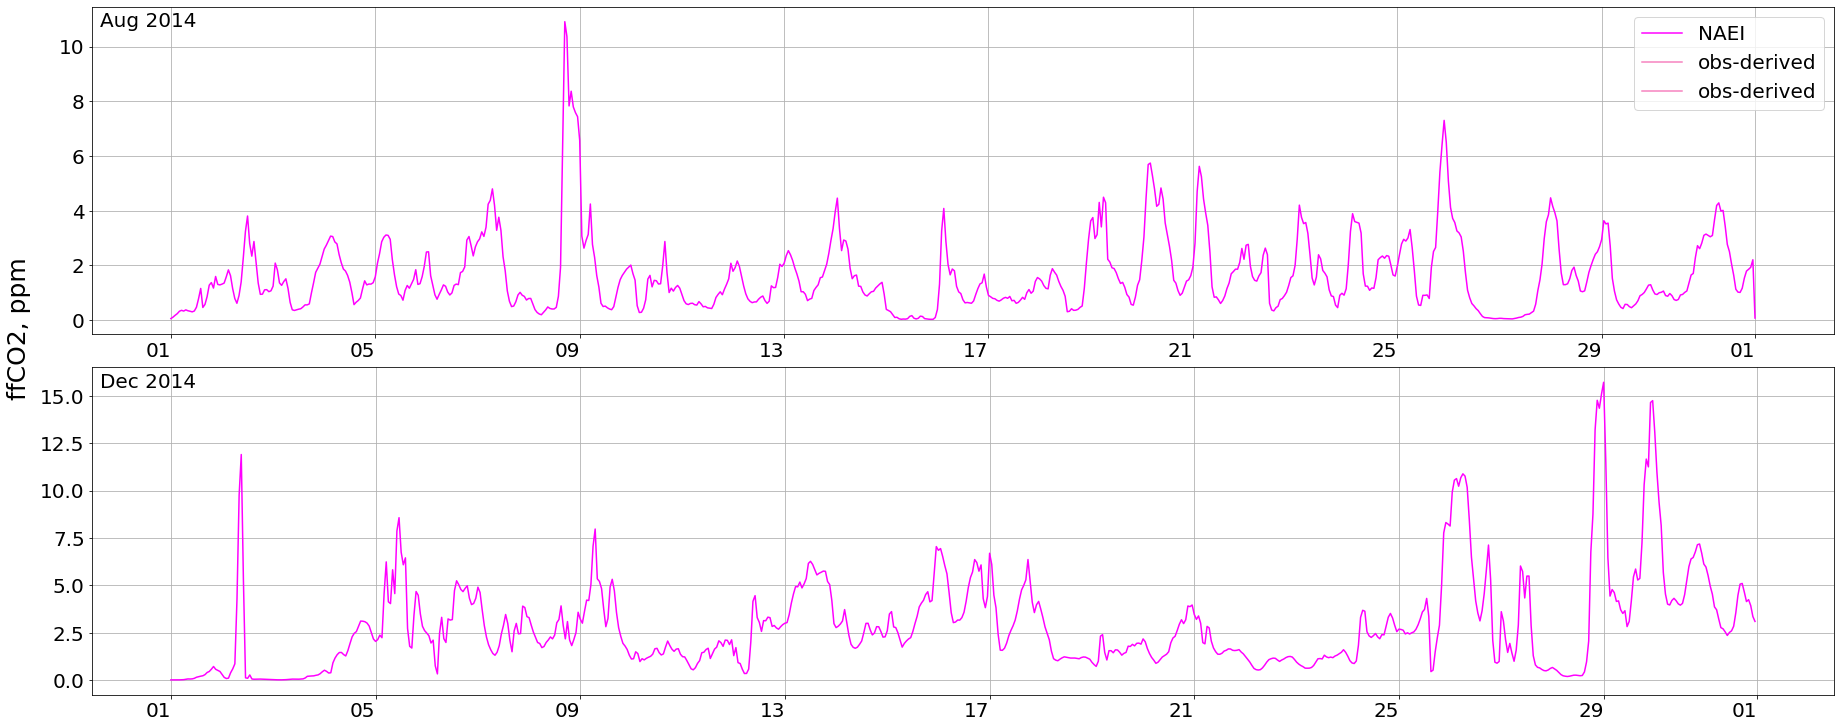

In [60]:
# plot the nemo & ecco models on separate axes
fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, 5*len(months)), constrained_layout=True)
axes = [axes] if type(axes) not in [np.ndarray, list] else axes

# plot the NAEI timeseries
[ts_data_month.co2_ff.plot(ax=axes[tt], label='NAEI', color='magenta')
 for tt, ts_data_month in enumerate(ts_data_months[site].values())]

# plot the APO-derived ffCO2 timeseries
apo_plots = {month: ff_month[site]['gridfed-ukghg'].plot(ax=axes[mm], label='obs-derived', color=apo_plot_info.colors['obs'])
             for mm, (month, ff_month) in enumerate(ffco2_obs.items())}
apo_plots2 = {month: ff_month[site].plot(ax=axes[mm], label='obs-derived', color=apo_plot_info.colors['obs'])
              for mm, (month, ff_month) in enumerate(ffco2_obs_const_ratio.items())}

text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
        for mm, month in enumerate(ffco2_ppm[site].keys())]

legend = axes[0].legend(loc='upper right', fontsize=20)
xlabel = [ax.set_xlabel('') for ax in axes]
ylabel = [ax.set_ylabel('') for ax in axes]

if len(months)==1:
        ylabel = axes.set_ylabel('ffCO2, ppm', fontsize=24)
if len(months)>1:
        ylabel = fig.text(-0.01, 0.55, 'ffCO2, ppm', va='center', ha='center', rotation='vertical', fontsize=25)

myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
grid = [ax.grid() for ax in axes]

out_date_str = f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
               '_'.join([f'{year}{str(month).zfill(2)}' for month in months])
mask_str = '' if ocean=='nonmasked' else '_maskedocean' if ocean=='masked' else f'oceanOR{ocean}'
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'ffCO2',
                        f'ffCO2_APO_obs{mask_str}_{site}_{out_date_str}.png')
# print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Calculate the correlations

In [39]:
rmse = {site: {month: {model: (((ffco2_sim['gridfed-ukghg'] - ts_data_months[site][month].co2_ff)**2).mean().values)**0.5
                       for model, ffco2_sim in ffco2_month.items()}
               for month, ffco2_month in ffco2_site.items()}
        for site, ffco2_site in ffco2_ppm.items()}

correlations = {site: {month: {model: xr.corr(ts_data_months[site][month].co2_ff, ffco2_sim['gridfed-ukghg'])
                               for model, ffco2_sim in ffco2_month.items()}
                       for month, ffco2_month in ffco2_site.items()}
                for site, ffco2_site in ffco2_ppm.items()}

In [40]:
print('RMSE')
print_rmse = [[print(f'{site}, {apo_plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ecco"]};   Jena: {rmse_month["jena"]};   NEMO: {rmse_month["nemo"]}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse.items()]
print('\nCorrelation')
print_corr = [[print(f'{site}, {apo_plot_info.month_names[month]} correlation:    ECCO: {corr_month["ecco"].values};   Jena: {corr_month["jena"].values};   NEMO: {corr_month["nemo"].values}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations.items()]

RMSE
WAO, Aug rmse:    ECCO: 3.7193551321891505;   Jena: 4.633165550305298;   NEMO: 5.481920540176577
WAO, Dec rmse:    ECCO: 4.387647608291727;   Jena: 4.788045843281246;   NEMO: 3.4706799209420263

Correlation
WAO, Aug correlation:    ECCO: 0.4563201848662594;   Jena: 0.3534013948637322;   NEMO: 0.46019490077571934
WAO, Dec correlation:    ECCO: 0.7748316590960699;   Jena: 0.6880232664006434;   NEMO: 0.8332211825536597


## Apply filter

In [41]:
ffco2_day = {site: {month: {sim: apo_filter.filter_time(dataset = ffco2_sim['gridfed-ukghg'],
                                                        site = 'WAO',
                                                        hour_start = 11,
                                                        hour_end = 15)
                                for sim, ffco2_sim in ffco2_month.items()}
                        for month, ffco2_month in ffco2_site.items()}
                 for site, ffco2_site in ffco2_ppm.items()}
ffco2_naei_day = {site: {month: apo_filter.filter_time(dataset = ffco2_month.co2_ff,
                                                       site = 'WAO',
                                                       hour_start = 11,
                                                       hour_end = 15)
                         for month, ffco2_month in ffco2_site.items()}
                  for site, ffco2_site in ts_data_months.items()}

In [42]:
rmse_day = {site: {month: {model: (((ffco2_sim - ffco2_naei_day[site][month])**2).mean().values)**0.5
                       for model, ffco2_sim in ffco2_month.items()}
               for month, ffco2_month in ffco2_site.items()}
        for site, ffco2_site in ffco2_day.items()}

correlations_day = {site: {month: {model: xr.corr(ffco2_naei_day[site][month], ffco2_sim)
                               for model, ffco2_sim in ffco2_month.items()}
                       for month, ffco2_month in ffco2_site.items()}
                for site, ffco2_site in ffco2_day.items()}

print('RMSE')
print_rmse = [[print(f'{site}, {apo_plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ecco"]};   Jena: {rmse_month["jena"]};   NEMO: {rmse_month["nemo"]}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse_day.items()]
print('\nCorrelation')
print_corr = [[print(f'{site}, {apo_plot_info.month_names[month]} correlation:    ECCO: {corr_month["ecco"].values};   Jena: {corr_month["jena"].values};   NEMO: {corr_month["nemo"].values}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations_day.items()]

RMSE
WAO, Aug rmse:    ECCO: 4.569589099086234;   Jena: 6.016901505570992;   NEMO: 7.023458250885429
WAO, Dec rmse:    ECCO: 4.500474428717694;   Jena: 4.728408888736715;   NEMO: 3.6877135017835685

Correlation
WAO, Aug correlation:    ECCO: 0.3039458648083659;   Jena: 0.2172456365690148;   NEMO: 0.38053605127013335
WAO, Dec correlation:    ECCO: 0.7483024569593305;   Jena: 0.6147009722869751;   NEMO: 0.7160152378989117


ValueError: x and y must have same first dimension, but have shapes (12,) and (2,)

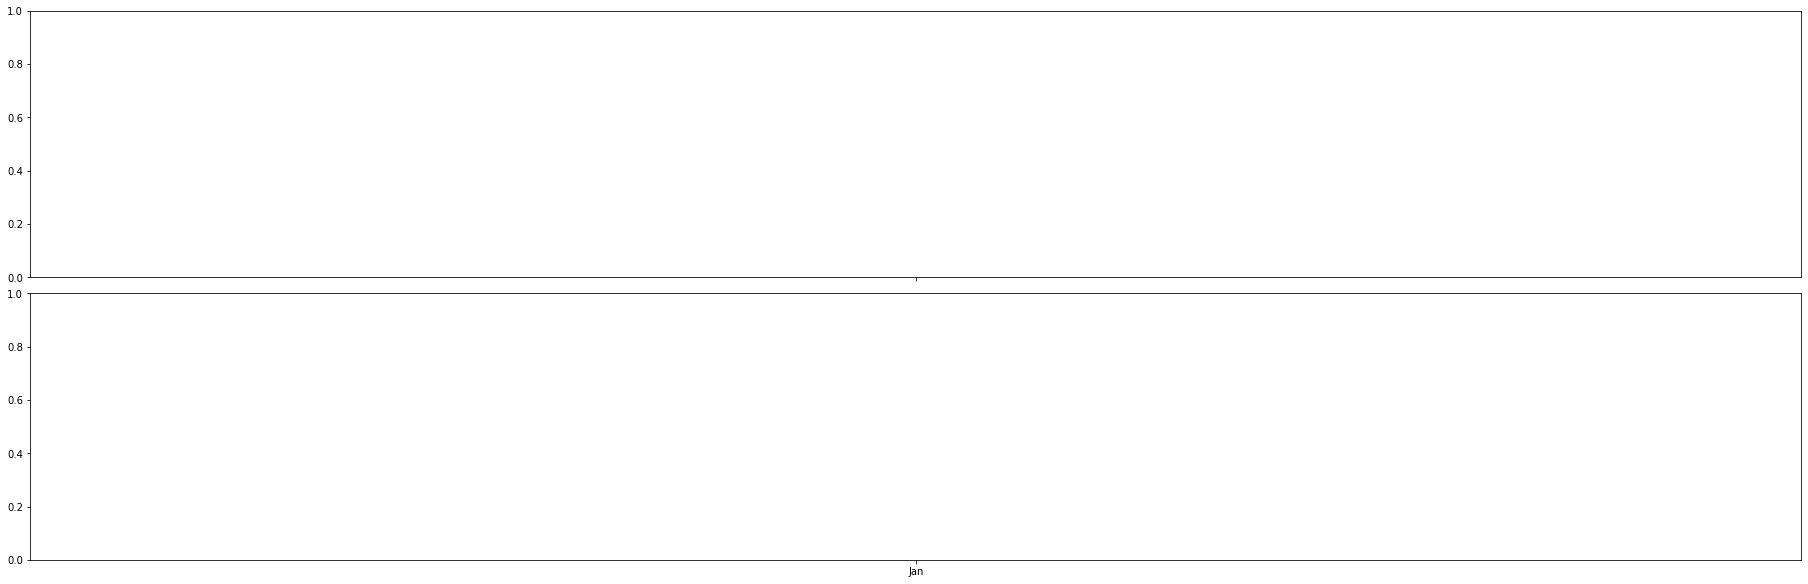

In [43]:
if len(months)>=12:
    sites_plot = ['WAO']

    plot_info_corr = {'unfiltered': {'label': '', 'ls':'-',
                                    'correlation': correlations,
                                    'rmse': rmse},
                    'daytime': {'label': ', daytime', 'ls': '--',
                                'correlation': correlations_day,
                                'rmse': rmse_day}}

    fig, axes = plt.subplots(nrows=2*len(sites_plot), ncols=1, figsize=(25, 8*len(sites_plot)), sharex=True, constrained_layout=True)

    for info in plot_info_corr.values():
        rmse_plot = [[axes[ss].plot(plot_info.month_names.values(), [rr[sim] for rr in info['correlation'][site].values()],
                                                    color=plot_info.colors[sim], label=f'{sim}{info["label"]}', ls=info['ls'])
                    for sim in ['ecco', 'jena', 'nemo']] for ss, site in enumerate(sites_plot)]

    for info in plot_info_corr.values():
        rmse_plot = [[axes[len(sites_plot)+ss].plot(plot_info.month_names.values(), [rr[sim] for rr in info['rmse'][site].values()],
                                                    color=plot_info.colors[sim], label=f'{sim}{info["label"]}', ls=info['ls'])
                    for sim in ['ecco', 'jena', 'nemo']] for ss, site in enumerate(sites_plot)]

    ticks = [ax.tick_params(labelsize=20) for ax in axes]
    # legend = axes[0].legend(loc='lower left', fontsize=16)
    legend = axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=20)
    grid = [ax.grid() for ax in axes]
    xlabels = [ax.set_xlabel('') for ax in axes]
    ylabels = [axes[ll].set_ylabel(label, fontsize=25)
            for ll, label in enumerate(['Correlation, R', 'RMSE, per meg'])]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO_correlations_{"-".join(sites_plot)}_{date_str}.png')

    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)